# Synopsis

We attempt a Naive Bayes classifier to predict authorship of the Federalist papers.

#  Configuration

In [1]:
base_path = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO'
local_lib = base_path + '/lib'
src_dir = base_path + '/labs/2019-02-28_Lab07/vierthaler-stylometry/fedpapers'

# Set Hyperparameters
params = dict(
    n_sets = 4,
    smooth_alpha = .01,
    binary_counts = True
)

# Libraries

In [78]:
import glob
import re
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

In [41]:
%matplotlib inline

# Process

## Import raw text data

In [3]:
files = glob.glob(src_dir+'/*.txt')
docs = pd.DataFrame([f.replace('.txt','').split('/')[-1].split('_') for f in files], 
                    columns=['doc_id','doc_label'])
docs['doc_content'] = [open(f, 'r', encoding='utf-8').read() for f in files]
docs['doc_id'] = docs['doc_id'].astype('int')
docs = docs.set_index('doc_id')
docs.doc_label = docs.doc_label.str[0]

In [4]:
docs.sort_index().head()

,doc_label,doc_content
doc_id,,
1,H,\n\n\nGeneral Introduction\n\nFor the Independ...
2,J,\n\n\nConcerning Dangers from Foreign Force an...
3,J,\n\n\nThe Same Subject Continued\n\n(Concernin...
4,J,\n\n\n\nThe Same Subject Continued\n\n(Concern...
5,J,\n\n\n\nThe Same Subject Continued\n\n(Concern...


In [5]:
paras = tx.split_by_delimitter(docs, div_name='para', div_pat=r'\n\n+', src_col='doc_content')

In [6]:
paras.head()

para
doc_id para_id                                                   
55     1         The Total Number of the House of Representatives
       2        From the New York Packet. Friday, February 15,...
       3                                      HAMILTON OR MADISON
       4                  To the People of the State of New York:
       5        THE number of which the House of Representativ...

In [7]:
tokens, vocab = tx.create_tokens_and_vocab(paras, src_col='para')

In [8]:
tokens = tokens.join(docs['doc_label'], on='doc_id', how='left').sort_index()

In [9]:
tokens.head()

token      term_str  term_id doc_label
doc_id para_id sent_id token_id                                               
1      1       0       0              General       general     3671         H
                       1         Introduction  introduction     4505         H
       2       0       2          Independent   independent     4198         H
                       3              Journal       journal     4618         H
       3       0       0             HAMILTON      hamilton     3796         H

In [10]:
tokens.doc_label.value_counts()

H    48945
M    19507
U    10609
J     3780
Name: doc_label, dtype: int64

In [11]:
tokens_unknown = tokens.query("doc_label == 'U'").copy()
tokens_known = tokens.query("doc_label != 'U'").copy()

In [12]:
LABELS = tokens_known.doc_label.unique().tolist()

In [13]:
priors = tokens_known.doc_label.value_counts() / tokens_known.doc_label.count()

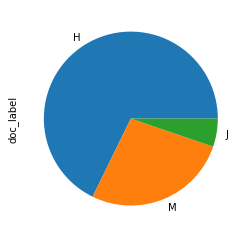

In [50]:
priors.plot(kind='pie')

In [51]:
logps = log(priors)

In [52]:
likelihoods = tokens.groupby(['term_id','doc_label']).token.count().unstack().fillna(0)
likelihoods = likelihoods + params['smooth_alpha']
likelihoods = likelihoods / likelihoods.sum()

In [53]:
likelihoods.head()

doc_label,H,J,M,U
term_id,,,,
61,0.000061,0.000003,1.028173e-04,9.388587e-07
62,0.000061,0.000003,5.115291e-07,9.388587e-07
67,0.000021,0.000003,1.539703e-04,9.388587e-07
70,0.000123,0.000526,5.115291e-07,9.388587e-07
71,0.000123,0.000003,5.115291e-07,9.482473e-05


In [54]:
likelihoods['class'] = likelihoods[LABELS].idxmax(1)
likelihoods['term_str'] = vocab.term_str

In [55]:
likelihoods.head()

doc_label,H,J,M,U,class,term_str
term_id,,,,,,
61,0.000061,0.000003,1.028173e-04,9.388587e-07,M,abandon
62,0.000061,0.000003,5.115291e-07,9.388587e-07,H,abandoned
67,0.000021,0.000003,1.539703e-04,9.388587e-07,M,abbe
70,0.000123,0.000526,5.115291e-07,9.388587e-07,J,abilities
71,0.000123,0.000003,5.115291e-07,9.482473e-05,H,ability


In [56]:
loglhs = log(likelihoods[LABELS])

In [57]:
loglhs.head()

doc_label,H,J,M
term_id,,,
61,-13.990355,-18.544055,-13.247629
62,-13.990355,-18.544055,-20.898680
67,-15.565763,-18.544055,-12.665061
70,-12.992753,-10.893003,-20.898680
71,-12.992753,-18.544055,-20.898680


In [58]:
tokens_unknown.head()

token       term_str  term_id  \
doc_id para_id sent_id token_id                                          
49     1       0       0                Method         method     5079   
                       2              Guarding       guarding     3778   
                       5         Encroachments  encroachments     2903   
                       8                   One            one     5503   
       2       0       0            Department     department     2234   

                                doc_label          H          J          M  
doc_id para_id sent_id token_id                                             
49     1       0       0                U -11.878569 -18.544055 -12.665061  
                       2                U -13.990355 -18.544055 -20.898680  
                       5                U -11.579217 -18.544055 -11.445410  
                       8                U  -7.425249  -6.408025  -7.094852  
       2       0       0                U -11.120031 -11.885844  -8.447212

In [60]:
try:
    tokens_unknown = tokens_unknown.join(loglhs[LABELS], on='term_id', how='inner').sort_index()
except ValueError:
    pass

In [62]:
tokens_unknown.head()

token       term_str  term_id  \
doc_id para_id sent_id token_id                                          
49     1       0       0                Method         method     5079   
                       2              Guarding       guarding     3778   
                       5         Encroachments  encroachments     2903   
                       8                   One            one     5503   
       2       0       0            Department     department     2234   

                                doc_label          H          J          M  
doc_id para_id sent_id token_id                                             
49     1       0       0                U -11.878569 -18.544055 -12.665061  
                       2                U -13.990355 -18.544055 -20.898680  
                       5                U -11.579217 -18.544055 -11.445410  
                       8                U  -7.425249  -6.408025  -7.094852  
       2       0       0                U -11.120031 -11.885844  -8.447212

In [63]:
docs_unknown = docs.query('doc_label == "U"').copy()

### Estimate probability for each label

In [64]:
for label in LABELS:
    docs_unknown[label] = tokens_unknown.groupby('doc_id')[label].apply(lambda x: logps[label] + np.sum(x))

In [65]:
docs_unknown.head()

,doc_label,doc_content,H,J,M
doc_id,,,,,
55,U,\n\n\n\nThe Total Number of the House of Repre...,-10022.975870,-11699.861382,-10163.341279
49,U,\n\n\n\nMethod of Guarding Against the Encroac...,-8034.733202,-9265.082645,-8139.294331
50,U,\n\n\n\nPeriodical Appeals to the People Consi...,-5565.146766,-6446.198463,-5640.550232
62,U,\n\n\n\nThe Senate\n\nFor the Independent Jour...,-11623.817926,-13235.775053,-11823.108861
53,U,\n\n\n\nThe Same Subject Continued (The House ...,-10417.942078,-11897.968906,-10661.131326


In [92]:
docs_unknown['prediction'] = docs_unknown[LABELS].idxmax(1)

In [93]:
docs_unknown.sort_index()

,doc_label,doc_content,H,J,M,prediction,doc_label2,result
doc_id,,,,,,,,
49,U,\n\n\n\nMethod of Guarding Against the Encroac...,-8034.733202,-9265.082645,-8139.294331,H,M,False
50,U,\n\n\n\nPeriodical Appeals to the People Consi...,-5565.146766,-6446.198463,-5640.550232,H,M,False
51,U,\n\n\n\nThe Structure of the Government Must F...,-9318.788084,-10887.889235,-9246.638259,M,M,False
52,U,\n\n\n\nThe House of Representatives\n\nFrom t...,-8980.571307,-10415.856364,-9123.963401,H,M,False
53,U,\n\n\n\nThe Same Subject Continued (The House ...,-10417.942078,-11897.968906,-10661.131326,H,M,False
54,U,\n\n\n\nThe Apportionment of Members Among the...,-9208.638118,-10804.333410,-9194.961312,M,M,False
55,U,\n\n\n\nThe Total Number of the House of Repre...,-10022.975870,-11699.861382,-10163.341279,H,M,False
56,U,\n\n\n\nThe Same Subject Continued (The Total ...,-7632.752179,-8719.681340,-7712.505249,H,M,False
57,U,\n\n\n\nThe Alleged Tendency of the New Plan t...,-10477.401595,-12535.380787,-10817.477432,H,M,False


```bash
H =  1, 6–9, 11–13, 15–17, 21–36, 59–61, and 65–85
M = 10, 14, 18–20,[12] 37–58 and 62–63
J = 2–5 and 64
```

In [94]:
actuals = [
    (49, 'M'),
    (50, 'M'),
    (51, 'M'),
    (52, 'M'),
    (53, 'M'),
    (54, 'M'),
    (55, 'M'),
    (56, 'M'),
    (57, 'M'),
    (58, 'M'),
    (62, 'M'),
    (63, 'M')
]

In [95]:
docs_unknown['doc_label2'] = pd.DataFrame(actuals, columns=['doc_id','doc_label2']).set_index('doc_id')['doc_label2']

In [113]:
docs_unknown.sort_index()

,doc_label,doc_content,H,J,M,prediction,doc_label2,result
doc_id,,,,,,,,
49,U,\n\n\n\nMethod of Guarding Against the Encroac...,-8034.733202,-9265.082645,-8139.294331,H,M,False
50,U,\n\n\n\nPeriodical Appeals to the People Consi...,-5565.146766,-6446.198463,-5640.550232,H,M,False
51,U,\n\n\n\nThe Structure of the Government Must F...,-9318.788084,-10887.889235,-9246.638259,M,M,True
52,U,\n\n\n\nThe House of Representatives\n\nFrom t...,-8980.571307,-10415.856364,-9123.963401,H,M,False
53,U,\n\n\n\nThe Same Subject Continued (The House ...,-10417.942078,-11897.968906,-10661.131326,H,M,False
54,U,\n\n\n\nThe Apportionment of Members Among the...,-9208.638118,-10804.333410,-9194.961312,M,M,True
55,U,\n\n\n\nThe Total Number of the House of Repre...,-10022.975870,-11699.861382,-10163.341279,H,M,False
56,U,\n\n\n\nThe Same Subject Continued (The Total ...,-7632.752179,-8719.681340,-7712.505249,H,M,False
57,U,\n\n\n\nThe Alleged Tendency of the New Plan t...,-10477.401595,-12535.380787,-10817.477432,H,M,False


In [108]:
docs_unknown['result'] = docs_unknown.doc_label2 == docs_unknown.prediction
CM = docs_unknown.reset_index().groupby(['prediction','doc_label2']).doc_id.count().unstack().fillna(0)

In [109]:
CM

doc_label2,M
prediction,
H,10
M,2
